In [1]:
# #installing keras-tuner
# !pip install keras-tuner

In [2]:
#importing necessary liabraries
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np


In [3]:
#loading dataset and spliting it in test and train dataset
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

In [4]:
#check x_train shape
x_train.shape


(60000, 28, 28)

In [5]:
#setting the y_train data
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

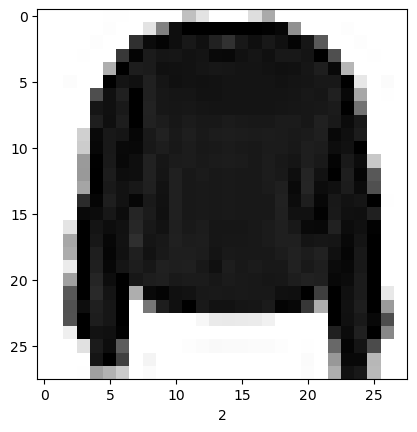

In [6]:
#checking a random element 7 and visualizing it
plt.imshow(x_train[7],cmap='binary')
plt.xlabel(y_train[7])
plt.show()

In [7]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping


def residual_block(input_tensor, filters):
    x = Conv2D(filters, kernel_size=(5, 5), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def create_model(hp=None):
    filters = 64
    dropout_rate = 0.25
    dense_units_1 = 256
    dense_units_2 = 128
    learning_rate = 0.001

    if hp:
        filters = hp.Choice('filters', values=[32, 64, 128])
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
        dense_units_1 = hp.Choice('dense_units_1', values=[128, 256, 512])
        dense_units_2 = hp.Choice('dense_units_2', values=[64, 128, 256])
        learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

    input_shape = (28, 28, 1)
    inputs = Input(shape=input_shape)

    # First backbone
    x1 = Conv2D(filters, kernel_size=(3, 3), activation='relu')(inputs)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = Dropout(dropout_rate)(x1)
    x1 = residual_block(x1, filters=filters)
    x1 = Dropout(dropout_rate)(x1)

    # Second backbone
    x2 = Conv2D(filters, kernel_size=(3, 3), activation='relu')(inputs)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(dropout_rate)(x2)
    x2 = residual_block(x2, filters=filters)
    x2 = Dropout(dropout_rate)(x2)

    # Concatenate the two backbones
    x = Concatenate()([x1, x2])
    
    x = Conv2D(filters, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)
    x = residual_block(x, filters=filters)
    x = Dropout(dropout_rate)(x)
    
    x = Flatten()(x)
    x = Dense(dense_units_1, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Dense(dense_units_2, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [8]:
#creating model summary
create_model(None).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 26, 26,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 13, 13,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 13, 13,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 13, 13,    │    102,464 │ dropout_4[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 13, 13,    │     36,928 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 13, 13,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 13, 13,    │          0 │ add_2[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 13, 13,    │          0 │ activation_5[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10816)     │          0 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,769,152 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_6[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 2,945,418 (11.24 MB)

 Trainable params: 2,944,394 (11.23 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [9]:
#defining a class with custom tuner using bayesian optimzation
class CustomTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self,trial, *args, **kwargs):
    kwargs['batch_size']=trial.hyperparameters.Int('batch_size',32,128,step=32) #giving batch size
    super(CustomTuner,self).run_trial(trial,*args,**kwargs)
    model = self.hypermodel.build(trial.hyperparameters)
    history = model.fit(x_train, y_train, validation_split=0.2, epochs=10)
    return history.history['val_accuracy'][-1]


In [10]:
#running a custom tuner
tuner=CustomTuner(
    create_model,
    objective='val_accuracy', #validation accuracy
    max_trials=20,           #defining max number of trials
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True
)

In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
dense_units_1 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
dense_units_2 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


In [12]:
# tuner.search(
#     x_train,y_train,
#     validation_data=(x_test,y_test),
#     epochs=5,verbose=False
# )

In [13]:
# tuner.results_summary(1)

In [14]:
# model=tuner.get_best_models(num_models=1)[0]
# model.summary()

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

y_train_2 = to_categorical(y_train, num_classes=10)
y_test_2 = to_categorical(y_test, num_classes=10)

model = create_model()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1)

fit = model.fit(
    x_train,y_train_2,
    validation_data=(x_test,y_test_2),
    epochs=20,batch_size=128,
    callbacks=[early_stopping_monitor, reduce_lr]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.8037 - loss: 0.5711 - val_accuracy: 0.8714 - val_loss: 0.3370 - learning_rate: 0.0010
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.8991 - loss: 0.2777 - val_accuracy: 0.9032 - val_loss: 0.2657 - learning_rate: 0.0010
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.9153 - loss: 0.2319 - val_accuracy: 0.9094 - val_loss: 0.2440 - learning_rate: 0.0010
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9214 - loss: 0.2103 - val_accuracy: 0.9126 - val_loss: 0.2405 - learning_rate: 0.0010
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.9295 - loss: 0.1883 - val_accuracy: 0.8992 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.9356 - loss: 0.1723 - val_accuracy: 0.8955 - val_loss: 0.2872 - learning_rate: 0.0010
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.9406 - l

In [16]:
model.evaluate(x_test, y_test_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9293 - loss: 0.2523


[0.2434195727109909, 0.9315000176429749]

In [17]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

def residual_block_1(input_tensor, filters):
    x = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def create_model_1(hp=None):
    filters = 64
    dropout_rate = 0.25
    dense_units_1 = 256
    dense_units_2 = 128
    learning_rate = 0.001

    if hp:
        filters = hp.Choice('filters', values=[32, 64, 128])
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
        dense_units_1 = hp.Choice('dense_units_1', values=[128, 256, 512])
        dense_units_2 = hp.Choice('dense_units_2', values=[64, 128, 256])
        learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

    input_shape = (28, 28, 1)
    inputs = Input(shape=input_shape)

    x = Conv2D(filters, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)
    x = residual_block(x, filters=filters)
    x = Dropout(dropout_rate)(x)
    x = residual_block(x, filters=filters)
    x = Dropout(dropout_rate)(x)
    
    x = Flatten()(x)
    x = Dense(dense_units_1, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(dense_units_2, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [18]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
model_1 = create_model_1()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping_monitor = EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1)

y_train_1 = to_categorical(y_train, num_classes=10)
y_test_1 = to_categorical(y_test, num_classes=10)

fit = model_1.fit(
    x_train, y_train_1,
    validation_data=(x_test, y_test_1),
    epochs=25, batch_size=128,
    callbacks=[early_stopping_monitor, reduce_lr]
)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 140ms/step - accuracy: 0.7488 - loss: 0.7236 - val_accuracy: 0.8845 - val_loss: 0.3163 - learning_rate: 0.0010
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.8823 - loss: 0.3301 - val_accuracy: 0.9025 - val_loss: 0.2690 - learning_rate: 0.0010
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.8997 - loss: 0.2750 - val_accuracy: 0.9063 - val_loss: 0.2581 - learning_rate: 0.0010
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.9082 - loss: 0.2480 - val_accuracy: 0.9022 - val_loss: 0.2626 - learning_rate: 0.0010
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 140ms/step - accuracy: 0.9151 - loss: 0.2298 - val_accuracy: 0.9103 - val_loss: 0.2381 - learning_rate: 0.0010
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.9198 - loss: 0.2165 - val_accuracy: 0.8872 - val_loss: 0.2951 - learning_rate: 0.0010
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 139ms/step - accuracy: 0.9

In [19]:
model_1.evaluate(x_test, y_test_1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9296 - loss: 0.2175


[0.20678886771202087, 0.9322999715805054]

In [20]:
from keras.models import load_model, Model
from keras.layers import Input, Average

# Load the pre-trained models
model_1 = model
model_2 = model_1

# Create a new input layer that matches the input shape of the original models
input_shape = (28, 28, 1)
inputs = Input(shape=input_shape)

# Get the outputs of the two models
output_1 = model_1(inputs)
output_2 = model_2(inputs)

# Average the outputs of the two models
averaged_output = Average()([output_1, output_2])

# Create a new model with the same input layer and the averaged output
ensemble_model = Model(inputs=inputs, outputs=averaged_output)

# Compile the new ensemble model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming X_train, y_train, X_validate, y_validate are already defined and preprocessed
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=10, monitor='val_accuracy', mode='min', verbose=1)

history_ensemble = ensemble_model.fit(x_train, y_train_1,
                                      batch_size=128,
                                      epochs=25,
                                      verbose=1,
                                      validation_data=(x_test, y_test_1),
                                      callbacks=[early_stopping_monitor, reduce_lr])

ensemble_model.save('model/ensemble_model.h5')

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 147ms/step - accuracy: 0.9740 - loss: 0.0000e+00 - val_accuracy: 0.9199 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.9780 - loss: 0.0000e+00 - val_accuracy: 0.9236 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.9760 - loss: 0.0000e+00 - val_accuracy: 0.9212 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 157ms/step - accuracy: 0.9799 - loss: 0.0000e+00 - val_accuracy: 0.9202 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 161ms/step - accuracy: 0.9806 - loss: 0.0000e+00 - val_accuracy: 0.9200 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 74s 157ms/step - accuracy: 0.9827 - loss: 0.0000e+00 - val_accuracy: 0.9241 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/25
469/469 ━━━

In [21]:
ensemble_model.evaluate(x_test, y_test_1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9261 - loss: 0.0000e+00


[0.0, 0.0, 0.9311000108718872, 0.9311000108718872]